---

## Overview

This coursework is provided as a Jupyter notebook, which you will need to complete.  

Throughout the notebook you will need to complete code, analytic exercises (if equations are required please typeset your solutions using latex in the markdown cell provided) and descriptive answers. Much of the grading of the coursework will be performed automatically, so it is critical you name your variables as requested.

Before you turn this coursework in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says "YOUR ANSWER HERE" or `YOUR CODE HERE` and remove remove the `raise NotImplementedError()` exceptions that are thrown before you have added your answers. Do not add and remove cells but rather provide your answers in the spaces given.

Please also:
- Make sure your notebook executes without errors.
- Do not overwrite or rename any existing variables.
- Do not install code or packages in the notebooks.

Please rename the notebook filename to include your name in the filename.  And please also add your name below:

In [1]:
NAME = "22036444"

You will be able to run some basic tests in the notebook to check the basic operation of your code is as expected.  Although do not assume your responses are complete or fully correct just because the basic tests pass.

Once you have renamed the notebook file and completed the exercises, please upload the notebook to Moodle.


---

## Dependencies

- Standard course dependencies (e.g. numpy, scikit-learn, etc.)
- [TensorFlow](https://www.tensorflow.org/)
- [TensorFlow DataSets](https://www.tensorflow.org/datasets)

---

Notes for people running the notebook in Google Colab:

- This notebook uses quite a bit of RAM (the solutions run with ~8.5Gb of RAM), which means that if you are very inefficient in your memory usage, it will not fit within Colab's limits of 12Gb. If this is the case, you can try restarting the runtime to free up memory of variables you have created and that you no longer use or write your code in a more efficient way.
- You can enable a Runtime with GPU acceleration for faster training (Runtime -> Change runtime type)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
def check_var_defined(var):
    try:
        exec(var)
    except NameError:
        raise NameError(var + " not defined.")
    else:
        print(var + " defined.")

# Part 1: Data pre-processing


In these exercises we will look at the classification of flowers into 5 different classes using convolutional neural networks (CNNs). The implementation of this will be done using TensorFlow (TF).

The dataset can be loaded in using the [Tensorflow Datasets](https://www.tensorflow.org/datasets) package. Below you see how we load in the data and change it from a TF generator object into a list of the images and a list of the targets. 

In [4]:
# Load data
data = tfds.load('tf_flowers', split=["train"], as_supervised=True)

# Dataset tf_flowers downloaded and prepared to C:\Users\BubbleTea\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.

In [5]:
images, targets = zip(*[i for i in data[0]])
labels = ["dandelion", "daisy", "tulips", "sunflowers", "roses"]

_Plot the first two images and their classes by writing a function `show_image`. Set the title of the images to be the class (use the actual label, not the number) it belongs to._ 

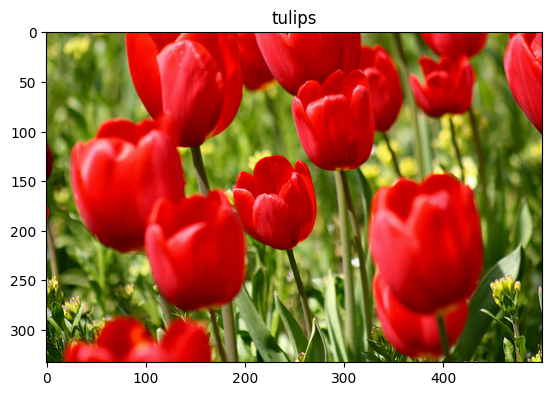

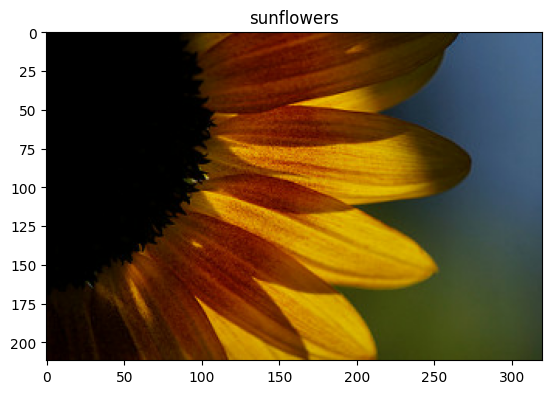

In [6]:
def show_image(image, target):
    plt.imshow(image)
    plt.title(labels[target])
    # plt.axis("off")
    plt.show()


for i in range(2):
    show_image(images[i], targets[i])

Before we can use the data to train neural networks, we need to pre-process the data such that:
    
- the images are all the same shape (224,224)
- the images, originally with values (0, 255), are mapped to have values between (0, 1)
- the labels are represented as one-hot vectors

_Write a function to rescale and resize the images._

In [7]:
def rescale_and_resize(image, dtype=tf.float32):
    image_float = tf.image.convert_image_dtype(image, dtype)
    image_float = tf.image.resize(image_float, (224, 224), method='bilinear')
    return tf.clip_by_value(image_float, 0.0, 1.0)

# rescale_and_resize(images[0]).numpy()

In [8]:
check_var_defined('rescale_and_resize')

rescale_and_resize defined.


_Now use the function to pre-process the data in the variable `images` and save the preprocessed images in an np.ndarray `images_preprocessed`._

In [9]:
a = [rescale_and_resize(img).numpy() for img in images]
images_preprocessed = np.stack(a)
images_preprocessed.shape

(3670, 224, 224, 3)

In [10]:
check_var_defined('images_preprocessed')
assert type(images_preprocessed) == np.ndarray, "Make sure to store your answer as a np.ndarray"

images_preprocessed defined.


One approach to represent the image labels so that they can be trainable by a neural network is to represented them as a one-hot vector. 

_Write a function `one_hot_encoding` that takes the integer label and returns a one-hot vector of the label._

In [11]:
def one_hot_encoding(target):
    a = np.zeros(len(labels))
    a[target] = 1
    return a


print(f"target: {targets[0]}, encoding: {one_hot_encoding(targets[0])}")

target: 2, encoding: [0. 0. 1. 0. 0.]


_Now use the function `one_hot_encoding` to create an np.ndarray of the one-hot representations of all the labels in `targets` and save them in `targets_preprocessed`._

In [12]:
targets_preprocessed = np.array([one_hot_encoding(t) for t in targets])
targets_preprocessed.shape

(3670, 5)

In [13]:
check_var_defined('targets_preprocessed')
assert type(targets_preprocessed) == np.ndarray, "Make sure to store your answer as a np.ndarray"

targets_preprocessed defined.


In this notebook you will train different models and compare them against each other. 

Now that the data is pre-processed. We will split the data in three datasets, a train, validation and test set. 

_Why do we need these three sets and what do we use them for._

We split the data into three subsets to improve and assess the performance of the model in an fair and unbiased way.

The train set is for training the model, the model parameters are adjusted every epoch to minimize loss.

The validation set is utilized to fine-tune the hyperparameters, such as the learning rate, the number of layers or units in the model, etc.
The model doesn't "see" the validation set and neither trained on it, but it brings insight for me (the model builder) so that I can tune the model according to these extra scores. It indirectly influences the model for it directly influences design decisions.

The test set is used to evaluate the performance of the final model. This set must be a 'never-seen' data for the model, meaning it should be entirely separated from the train and validation sets. Evaluate the model on this set is like a mock test that gives an unbiased estimation of its performance on new data, so to make sure the model performs well in actual deployed user scenarios.

The over all point of dividing the data into three subsets is to mitigate the issues of overfitting, where the model memorizes the training data but struggles with new data, and underfitting, where the model is too simplistic and cannot discern the patterns in the data.

$%answered$

_Now split the data such that we have a train set with 80\% of the samples and a validation and test set each with 10\% of the samples. Save the results in `x_train`, `y_train`, `x_val`, `y_val`, `x_test`, and `y_test`._

In [14]:
tf.keras.utils.set_random_seed(371947)

n = targets_preprocessed.shape[0]
indices = np.arange(n)
rest_size = int(.2 * n)
test_size = rest_size // 2
idxs = np.random.choice(indices, size=rest_size, replace=False)

x_train = images_preprocessed[~idxs, ...]
y_train = targets_preprocessed[~idxs, ...]

x_val = images_preprocessed[idxs[:test_size], ...]
y_val = targets_preprocessed[idxs[:test_size], ...]

x_test = images_preprocessed[idxs[test_size:], ...]
y_test = targets_preprocessed[idxs[test_size:], ...]

print(f"Train samples: {len(x_train)}, Validation samples: {len(x_test)}, Test samples: {len(x_val)}")

Train samples: 734, Validation samples: 367, Test samples: 367


In [15]:
check_var_defined('x_train')
check_var_defined('y_train')

check_var_defined('x_val')
check_var_defined('y_val')

check_var_defined('x_test')
check_var_defined('y_test')

x_train defined.
y_train defined.
x_val defined.
y_val defined.
x_test defined.
y_test defined.


WARNING: Before we continue we delete the variable `images_preprocessed` (you don't need that anymore) to manage our RAM consumption. If you want to use that variable again you will have to rerun the cell that creates it.

In [16]:
# Freeing up RAM by deleting this variable
del images_preprocessed

# Part 2: Training a basic CNN model 

Now that we have pre-processed the data and split it into different parts for training, validation and testing, you can start training some neural networks.

Our model will take as input the $224 \times 224$ rgb (3-channel) images and will give as output a length five vector of which the different elements correspond to the five different classes. 

The model will start with convolutional layers followed by a hidden dense layer and then the final dense layer that gives us our output. 

_What kind of activation function should we use on the convolutional, dense and output layers and why these specific activation functions? (motivate your answers)_


1. Use **ReLU** for **convolutional layers**
    - It sets all negative values to zero without changing positive values, which makes it computationally efficient.

    - It avoids the vanishing gradient problem by maintaining the gradient signal through backpropagation.

2. Use **ReLU** for the **hidden dense layer**

    - Despite its simplicity and efficiency, and the benefit of preventing gradient vanishing problem;
    - It also adds sparsity to the intermediate output (e.i., many zeros), which can help with regularization and prevent overfitting.

3. Use **Softmax** for the **output Layer**
    - Softmax converts the output of the last dense layer into a probability distribution over the classes, ensuring that the sum of the probabilities is equal to one.

$%answered$

_Create a model using the `tf.keras.models.Sequential()` model and add to that:_

- Input layer: A 2D convolutional layer with 8 filters, a 3x3 kernel and the ReLU activation function. Specify that this layer has an `input_shape` of (224, 224, 3)_ 
- A 2D MaxPool layer with strides 2x2

- A 2D convolutional layer with 16 filters, a 3x3 kernel and a the ReLU activation function
- A 2D MaxPool layer with strides 2x2

- A 2D convolutional layer with 32 filters, a 3x3 kernel and a the ReLU activation function
- A 2D MaxPool layer with strides 2x2

- A 2D convolutional layer with 32 filters, a 3x3 kernel and a the ReLU activation function
- A 2D MaxPool layer with strides 2x2

- A Flatten layer to flatten the filters to a single vector
- A Dense layer with 32 nodes and your chosen activation

- Output layer: A Dense layer with 5 nodes and your chosen activation

_Store the model in the variable `model_basic`._

In [17]:
tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(93612)
kernel_size = (3, 3)
stride = (2, 2)

model_basic = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, kernel_size, activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(stride),
    tf.keras.layers.Conv2D(16, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(stride),
    tf.keras.layers.Conv2D(32, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(stride),
    tf.keras.layers.Conv2D(32, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(stride),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [18]:
check_var_defined('model_basic')

model_basic defined.


To compile the model we need to specify a loss function. 

_What loss function would be appropriate for this multi-class classfication problem?_

_Also, during training we would like to monitor how well our model performs on predicting the targets. What would be a good metric to track? Motivate your answers._ 

For the loss, the `CategoricalCrossentropy()` loss would be appropriate. The categorical cross-entropy loss function is widely used for multi-class classification problems as it calculates the difference between the predicted probability distribution and the true probability distribution. This loss function is suitable for this problem because it measures the dissimilarity between the true and predicted class probabilities.

As for the metric to track during training, accuracy would be a good choice. Since we are dealing with a multi-class classification problem, we can use `CategoricalAccuracy()`, which calculates the average accuracy rate across all classes. It is an intuitive and easy-to-understand metric that can be used to evaluate the overall performance.
$%answered$

Now compile the model using the `Adam` optimiser, your chosen loss, and your chosen metric to track. (Tip: TF has some loss function and metrics implemented in [tf.keras.losses](https://www.tensorflow.org/api_docs/python/tf/keras/losses) and [tf.keras.metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics).)

In [19]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

model_basic.compile(optimizer=Adam(),
                    loss=CategoricalCrossentropy(),
                    metrics=[CategoricalAccuracy()])


In [20]:
check_var_defined('model_basic')

model_basic defined.


_Now fit the train data for 10 epochs and save the training history in the variable `history_basic`. Also specify the `validation_data` and a `batch_size` of 32._

In [21]:
tf.keras.utils.set_random_seed(47290)
history_basic = model_basic.fit(x_train, y_train,
                                epochs=10,
                                batch_size=32,
                                validation_data=(x_val, y_val))


Epoch 1/10
23/23 [==============================] - 9s 49ms/step - loss: 1.5745 - categorical_accuracy: 0.3188 - val_loss: 1.4628 - val_categorical_accuracy: 0.3706
Epoch 2/10
23/23 [==============================] - 1s 25ms/step - loss: 1.3693 - categorical_accuracy: 0.4033 - val_loss: 1.3875 - val_categorical_accuracy: 0.3842
Epoch 3/10
23/23 [==============================] - 1s 24ms/step - loss: 1.2259 - categorical_accuracy: 0.4659 - val_loss: 1.2661 - val_categorical_accuracy: 0.4196
Epoch 4/10
23/23 [==============================] - 1s 24ms/step - loss: 1.1973 - categorical_accuracy: 0.4728 - val_loss: 1.3122 - val_categorical_accuracy: 0.4087
Epoch 5/10
23/23 [==============================] - 1s 24ms/step - loss: 1.0670 - categorical_accuracy: 0.5681 - val_loss: 1.1248 - val_categorical_accuracy: 0.5123
Epoch 6/10
23/23 [==============================] - 1s 24ms/step - loss: 1.0139 - categorical_accuracy: 0.5763 - val_loss: 1.0994 - val_categorical_accuracy: 0.5559
Epoch 7/10

In [22]:
check_var_defined('history_basic')

history_basic defined.


_Now to see how the model performs, write a function `plot_metrics` that plots the loss for the train and validation set. In the same function also create a separate plot that plots the other metric for the train and validation set._

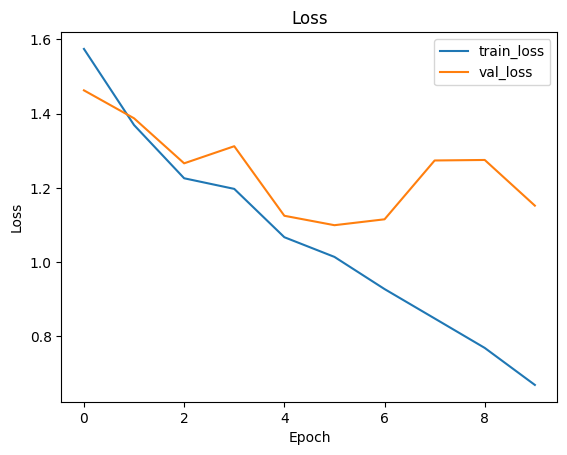

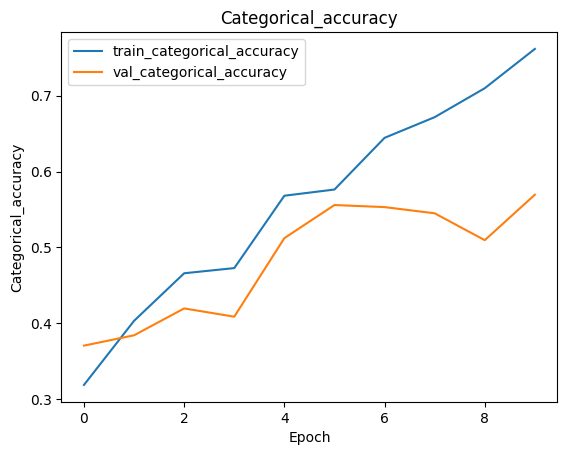

In [23]:
def plot_metrics(history):
    metrics = ['loss', 'categorical_accuracy']
    for metric in metrics:
        plt.plot(history.history[metric], label=f'train_{metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.title(metric.capitalize())
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()


plot_metrics(history_basic)

_Comment on the performance of the model based the tracked loss and metric_

Based on the tracked loss and metric, it appears that the model is improving its ability to classify the data.

The training loss is steadily decreasing, which suggests that the model is learning to better fit the training data; the training accuracy is steadily increasing, indicating that the model is becoming more accurate at predicting the correct classes for the training data.

However, the validation loss and accuracy do not show such steady improving trends comparing with train loss and accuracy. It seems to fluctuate more and even decrease slightly after some epochs.

This suggests that the model may be overfitting the training data, meaning that it is becoming too specialized to the training set and unable to generalize well to new, unseen data. To address this, further regularization techniques may need to be applied, such as dropout or weight decay.

Overall, while the training performance is encouraging, more attention needs to be paid to the validation performance, and further improvements may be necessary to achieve better generalization to new data.

*What happens if we were to train the model for more epochs? What will happen to the performance of the model?*

For the first few more epoches, the loss on the training set will continue to decrease and the accuracy on the validation set will continue to increase slightly fluctuations.

But after training for too many epochs, the loss on the training set will stop decreasing, and the accuracy on the validation set will stop improving or even starts to decrease. This indicates that the model has reached its optimal performance, and continuing training would just result in overfitting to the train data, leading to worse performance on new, unseen data(e.g., the test datset).
$%answered$

*Write a function `model_predict` that takes the model and some image data and returns the predicted targets (as integers corresponding to the predicted labels).* 

In [24]:
def model_predict(model, data):
    return np.argmax(model.predict(data), axis=1)

_Gather the targets of the test set (scalar integer value corresponding to the labels) and save them in `test_targets`._

_Compute the targets for `model_basic` and store them in the variable `test_targets_basic`._

In [25]:
test_targets = np.where(y_test != 0)[1]
test_targets_basic = model_predict(model_basic, x_test)

12/12 [==============================] - 0s 8ms/step


In [26]:
check_var_defined('test_targets')
check_var_defined('test_targets_basic')

assert test_targets.ndim == 1, "Make sure you are only predicting the scalar label value not the one hot vectors"
assert test_targets_basic.ndim == 1, "Make sure you are only predicting the scalar label value not the one hot vectors"

test_targets defined.
test_targets_basic defined.


_Calculate the precision and recall averaged over the 5 classes. (Precision and recall for each classes and then avaraged in one score)_

In [27]:
from sklearn.metrics import precision_score, recall_score


def average_recall_precision(y, y_predict):
    precision = precision_score(y, y_predict, average=None)
    recall = recall_score(y, y_predict, average=None)
    print(f'precision:\n{precision}')
    print(f'recall:\n{recall}')
    precision = np.mean(precision)
    recall = np.mean(recall)
    print(f"\nAverage Recall: {recall:.3f}, Average Precision {precision:0.3f}")
    return recall, precision


recall_basic, precision_basic = average_recall_precision(test_targets, test_targets_basic)

precision:
[0.60330579 0.64516129 0.52325581 0.60810811 0.61818182]
recall:
[0.72277228 0.31746032 0.58441558 0.77586207 0.5       ]

Average Recall: 0.580, Average Precision 0.600


In [28]:
check_var_defined('recall_basic')
check_var_defined('precision_basic')

recall_basic defined.
precision_basic defined.


_Show the predicted targets in a confusion matrix. Show the predicted labels in percentages (percentage of the samples from true class labeled as predicted class) and add the labels to the axes._

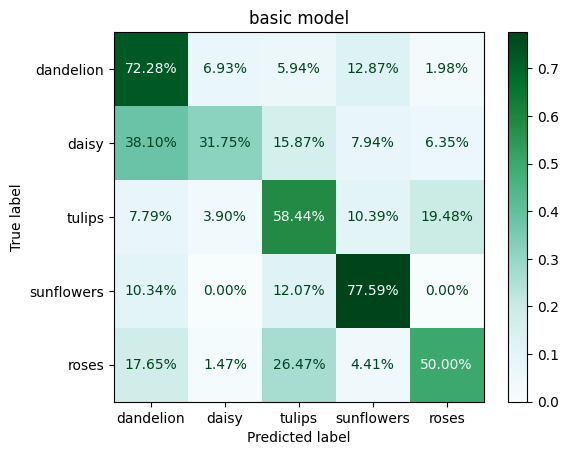

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def plot_confusion_matrix(y, y_pred, title=""):
    cm = confusion_matrix(y, y_pred, normalize='true')  # todo
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(values_format='.2%', cmap='BuGn')
    plt.title(title)
    plt.show()
    return cm


cm = plot_confusion_matrix(test_targets, test_targets_basic, "basic model")

_Comment on the recall and precision of the model, as well as the predictions in the confusion matrix._

# recall and precision
The recall and precision scores provide an insight into the performance of a classification model. The recall score represents the model's ability to correctly identify all relevant samples, while the precision score shows how often the model correctly identified positive samples.

The average recall score tells us how only 53.8% of the samples that actually belong is a certain type of flower were correctly predicted by the model as being that type of flower.
The averaged precision score tells us 56.3% of the samples that the model predicted to be as a certain flower actually is that type of flower.

The model's performance is only slightly better than random guessing, who would have an average recall and precision score of 0.2 (assuming a balanced dataset). Therefore, the model still needs improvements.

# predictions in confusion matrix
The model demonstrates satisfactory performance for certain classes.
- For example, the model performs quite well for dandelions, with a recall of 74.26%, signifying its ability to distinguish dandelions from other flowers .
- The same goes for sunflowers as well, for the relatively accurate predicts(77.6%).

However, it appears that the model struggles to distinguish between certain classes.
- Specifically, more than half (52.38%) of daisies are wrongly identified as dandelions, meaning that the model tends to mistaken daisies as dandelions.
- Additionally, the model exhibits poor performance in recognizing roses, with a recall of only 45.6%, indicating its inability to accurately capture the key features of roses.

The confusion matrix indicates that the model has some difficulty distinguishing between certain classes,and has not learnt essential features for certain categories.

Overall, both the scores and matrix suggest that the model is not performing very well, and could benefit from training with more data.

# Part 3: Improving the model

To improve on the model we will include some Dropout layers. 

_What do dropout layers do and why might this increase the performance of our models?_

Dropout layers are a regularization technique used in neural networks to prevent overfitting. During the training phase, a certain percentage (e.g., 0.5) of the neurons in a layer are randomly "dropped out" by setting their outputs to zero.

By randomly dropping out neurons, each neuron must learn to make predictions in the absence of other neurons, which forces them to learn ore essential features. Dropout also acts as a form of ensemble learning, since during each training different neurons are dropped out, resulting in slightly different predictions.

In the context of this problem, dropout layers can be added to the neural network architecture to improve generalization and prevent overfitting. Analysis of above shows that the model may be overfitting to the training data. Therefore, by encouraging the network to learn more robust features and reducing its dependence on any one input feature, dropout can help improve the network's ability to generalize to new, unseen data.

$%answered$

Another method to improve the model is by using a technique called data augmentation. 

_Explain the concept data augmentation and explain how it might increase the performance of our model._

Data augmentation is a technique used to increase the size of the training dataset by artificially generating new training examples through the application of various random transformations like rotation, flipping, zooming, or shifting. This technique improves the model's ability to generalize to new data by introducing more variations of the input images into the training set.

By applying data augmentation such as rotation and flipping, we can create new images with slight variations. This can help the model learn to recognize the transformation-invariant features of different types of flowers, such as the shape and the color of the petals, and thus reduce over-fitting, and make it more robust and generalized to variations in the input data.

_Use the exact same model as for the `model_basic`, but play around with adding in a data augmentation layer (e.g. [tf.keras.layers.RandomFlip](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip) ) and adding in dropout layers (dropout is typically only added in the dense part of the network). Store the new model in the variable `model_dropout` and compile it using the same metrics and loss as before._

In [30]:
tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(48263)

kernel_size = (3, 3)
stride = (2, 2)

model_dropout = tf.keras.models.Sequential([
    tf.keras.layers.RandomFlip('horizontal', input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(8, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(stride),
    tf.keras.layers.Conv2D(16, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(stride),
    tf.keras.layers.Conv2D(32, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(stride),
    tf.keras.layers.Conv2D(32, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(stride),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(5, activation='softmax')
])


model_dropout.compile(optimizer=Adam(),
                    loss=CategoricalCrossentropy(),
                    metrics=[CategoricalAccuracy()])


In [31]:
check_var_defined('model_dropout')

model_dropout defined.


_Fit the new model in the same way as before and save the history in `history_dropout`. However, train for 20 epochs instead of 10._

In [32]:
tf.keras.utils.set_random_seed(103745)

history_dropout = model_dropout.fit(x_train, y_train,
                                epochs=20,
                                batch_size=32,
                                validation_data=(x_val, y_val))


Epoch 1/20
23/23 [==============================] - 1s 38ms/step - loss: 1.6065 - categorical_accuracy: 0.2248 - val_loss: 1.5870 - val_categorical_accuracy: 0.2725
Epoch 2/20
23/23 [==============================] - 1s 35ms/step - loss: 1.5357 - categorical_accuracy: 0.3215 - val_loss: 1.5025 - val_categorical_accuracy: 0.3760
Epoch 3/20
23/23 [==============================] - 1s 30ms/step - loss: 1.4622 - categorical_accuracy: 0.3733 - val_loss: 1.3741 - val_categorical_accuracy: 0.4169
Epoch 4/20
23/23 [==============================] - 1s 31ms/step - loss: 1.4134 - categorical_accuracy: 0.3733 - val_loss: 1.3306 - val_categorical_accuracy: 0.4278
Epoch 5/20
23/23 [==============================] - 1s 30ms/step - loss: 1.3533 - categorical_accuracy: 0.4005 - val_loss: 1.2495 - val_categorical_accuracy: 0.4823
Epoch 6/20
23/23 [==============================] - 1s 29ms/step - loss: 1.3064 - categorical_accuracy: 0.4428 - val_loss: 1.2214 - val_categorical_accuracy: 0.5150
Epoch 7/20

In [33]:
check_var_defined('history_dropout')

history_dropout defined.


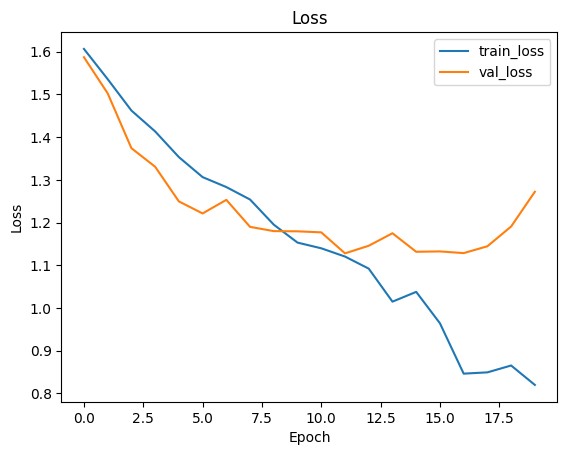

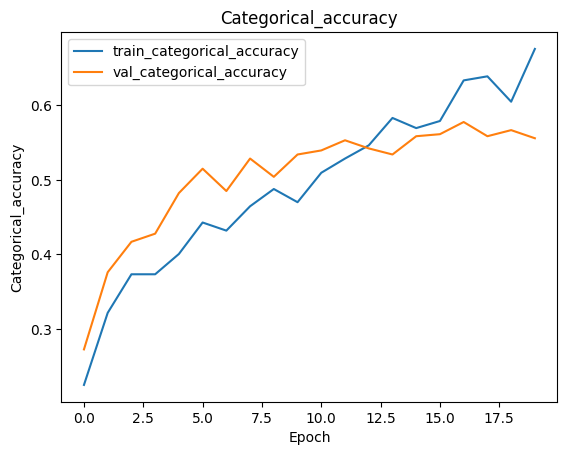

In [34]:
plot_metrics(history_dropout)

_Comment on the performance of the improved model based on the loss and metrics during training._

we can see that the loss decreases steadily throughout the training process, indicating that the model is learning and improving. Similarly, the categorical accuracy and validation categorical accuracy both improve during training, which is a good sign that the model is becoming more accurate at predicting the correct class labels for the input data.

However, we can also see that the model starts to overfit the training data around epoch 13, as evidenced by the fact that the validation loss starts to increase while the training loss continues to decrease. This suggests that the model is becoming too specialized to the training data.

Compared to `model_basic` in general, the `model_dropout` has achieved lower training and validation losses and higher training and validation categorical accuracies, with less fluctuation of the decrease/increase curve. However, the training process of model_dropout has taken more epochs to converge than model_basic, indicating that it is somewhat more complex.

 Overall, the improved model_dropout has demonstrated better performance and a more robust training process than model_basic, but more experimentation and tuning may be necessary to further improve its performance.

_Why did we have to train the model for longer than the basic model?_

Dropout randomly deactivates neurons during training, which can slow down the convergence of the network to an optimal solution. Moreover, since dropout adds randomness to the training process, it increases the variance of the gradients, making it harder for the network to converge as well.

Data augmentation creates new images during each epoch, which can increase the time required to process the data. Additionally, the augmentation process itself may require extra time.

Hence, we may need to train the model longer to ensure that it has enough time to learn from the augmented data and adjust to the dropout layer.

Now we evaluate our model on the test set using the functions you wrote before

12/12 [==============================] - 0s 9ms/step
precision:
[0.60740741 0.8        0.56626506 0.58208955 0.56756757]
recall:
[0.81188119 0.57142857 0.61038961 0.67241379 0.30882353]

Average Recall: 0.595, Average Precision 0.625


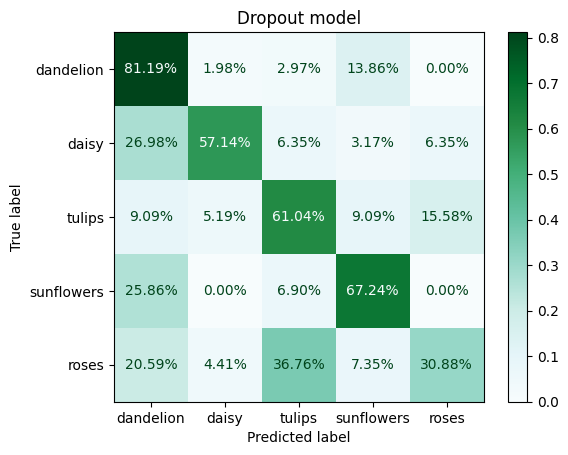

array([[0.81188119, 0.01980198, 0.02970297, 0.13861386, 0.        ],
       [0.26984127, 0.57142857, 0.06349206, 0.03174603, 0.06349206],
       [0.09090909, 0.05194805, 0.61038961, 0.09090909, 0.15584416],
       [0.25862069, 0.        , 0.06896552, 0.67241379, 0.        ],
       [0.20588235, 0.04411765, 0.36764706, 0.07352941, 0.30882353]])

In [35]:
test_targets_dropout = model_predict(model_dropout, x_test)
recall_dropout, precision_dropout = average_recall_precision(test_targets, test_targets_dropout)
plot_confusion_matrix(test_targets, test_targets_dropout, "Dropout model")


In [36]:
check_var_defined('test_targets_dropout')
check_var_defined('recall_dropout')

test_targets_dropout defined.
recall_dropout defined.


In [37]:
check_var_defined('test_targets_dropout')
check_var_defined('precision_dropout')

test_targets_dropout defined.
precision_dropout defined.


_Comment on the precision and recall of the model as well as the predictions in the confusion matrix_

 - In this confusion matrix, the recall for dandelion is high (75.25%), which means that 75.25% of the actual dandelion are correctly predicted. The recall for tulips is also relatively high (71.43%).

- However, the recall for daisy is lower (53.97%), probably means the model still cannot capture essential features of daisies, therefore the wrong predictions of actual daisies are spread over other 4 classes.

- The recall score is particularly low for roses (32.35%), since most(48.53%) of roses are mistaken as tulips, suggesting that the model cannot well distinguish roses from tulips.

While the overall avaranged precision and recall for the model indicate that the model has an acceptable average performance, take into consideration the analysis of the confusion matrix above, though the model indeed has some strengths in recognizing certain flowers, its performance is not consistent across all classes, and it may need further improvement for certain flowers, especially roses.

# Part 4: Transfer learning

In order to improve our model even further, we will make use of transfer learning. 

_Explain in your own words what tranfer learning means and why it would help in our particular case._

Transfer learning is a technique in machine learning where a pre-trained model is used as a starting point for a new model. Rather than starting from scratch, the new model is built on top of the pre-trained model, which has already learned to recognize common patterns in large datasets.

In our case, transfer learning would help us to leverage the knowledge learned by a larger and more complex network such as MobileNet, that have already been trained on ImageNet dataset. These pre-trained model has already learned to recognize many common patterns in images, such as edges, shapes, and textures, which can be utilized to ease training work load. We can use the MobileNet as a starting point, and fine-tune it on the flower dataset. This can help improve the accuracy and speed of the model, as well as reduce the time required to train a complex model from scratch.



Below you can see how we load in a pre-trained MobileNet that is trained on the ImageNet datastet. By not including the top part of the network we get only the convolutional layers and can add our own dense layers after that. We set all the layers of the MobileNet as not trainable, since this would be computationally expensive to do and we also want to avoid overfitting. Instead we will only be training the dense part. 

In [38]:
mobilenet = tf.keras.applications.mobilenet.MobileNet(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

for layer in mobilenet.layers:
    layer.trainable = False

print("Output shape of the MobileNet: ", mobilenet.output_shape)

Output shape of the MobileNet:  (None, 7, 7, 1024)


_Use a sequential model and add the MobileNet, followed by a MaxPool2D layer, and then the dense part of the network which you can use the same as we have used in the previous models. Store the model in the variable `model_mobilenet`. Compile the model using the same metrics, loss and optimiser as before._

In [39]:
tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(387453)

kernel_size = (3, 3)
stride = (2, 2)

model_mobilenet = tf.keras.models.Sequential([
    mobilenet,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])


model_mobilenet.compile(optimizer=Adam(),
                      loss=CategoricalCrossentropy(),
                      metrics=[CategoricalAccuracy()])
model_mobilenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 1024)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 32)                294944    
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 3,523,973
Trainable params: 295,109
Non-tr

In [40]:
check_var_defined('model_mobilenet')

model_mobilenet defined.


*Train the model in the same way as before, for 10 epochs.*

In [41]:
tf.keras.utils.set_random_seed(9673)

history_mobilenet = model_mobilenet.fit(x_train, y_train,
                                    epochs=10,
                                    batch_size=32,
                                    validation_data=(x_val, y_val))

Epoch 1/10
23/23 [==============================] - 2s 57ms/step - loss: 1.2237 - categorical_accuracy: 0.6267 - val_loss: 0.8052 - val_categorical_accuracy: 0.6975
Epoch 2/10
23/23 [==============================] - 1s 36ms/step - loss: 0.3916 - categorical_accuracy: 0.8556 - val_loss: 0.5102 - val_categorical_accuracy: 0.8610
Epoch 3/10
23/23 [==============================] - 1s 36ms/step - loss: 0.1897 - categorical_accuracy: 0.9319 - val_loss: 0.5000 - val_categorical_accuracy: 0.8365
Epoch 4/10
23/23 [==============================] - 1s 36ms/step - loss: 0.0645 - categorical_accuracy: 0.9837 - val_loss: 0.4866 - val_categorical_accuracy: 0.8638
Epoch 5/10
23/23 [==============================] - 1s 35ms/step - loss: 0.0272 - categorical_accuracy: 0.9932 - val_loss: 0.4698 - val_categorical_accuracy: 0.9019
Epoch 6/10
23/23 [==============================] - 1s 35ms/step - loss: 0.0093 - categorical_accuracy: 1.0000 - val_loss: 0.4814 - val_categorical_accuracy: 0.8828
Epoch 7/10

In [42]:
check_var_defined('history_mobilenet')

history_mobilenet defined.


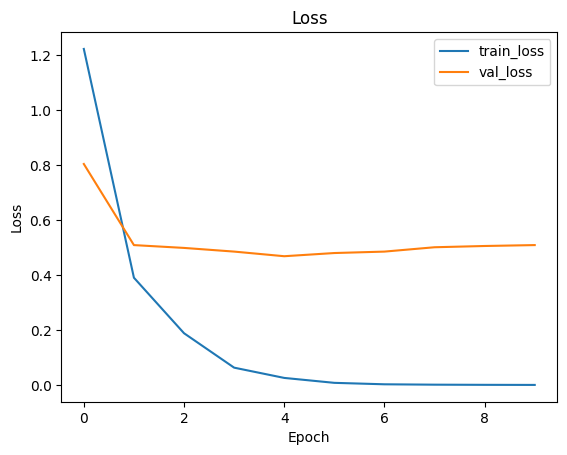

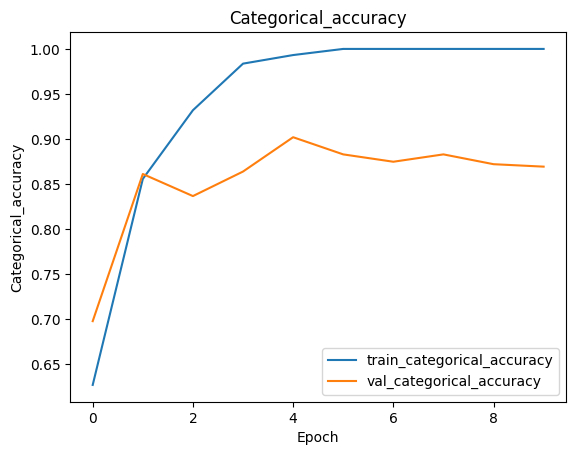

In [43]:
plot_metrics(history_mobilenet)

12/12 [==============================] - 1s 19ms/step
precision:
[0.96808511 0.86567164 0.88157895 0.84126984 0.91044776]
recall:
[0.9009901  0.92063492 0.87012987 0.9137931  0.89705882]

Average Recall: 0.901, Average Precision 0.893


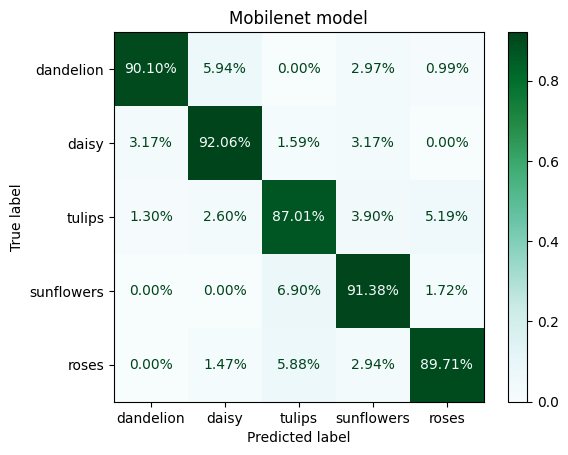

array([[0.9009901 , 0.05940594, 0.        , 0.02970297, 0.00990099],
       [0.03174603, 0.92063492, 0.01587302, 0.03174603, 0.        ],
       [0.01298701, 0.02597403, 0.87012987, 0.03896104, 0.05194805],
       [0.        , 0.        , 0.06896552, 0.9137931 , 0.01724138],
       [0.        , 0.01470588, 0.05882353, 0.02941176, 0.89705882]])

In [44]:
test_targets_mobilenet = model_predict(model_mobilenet, x_test)
recall_mobilenet, precision_mobilenet = average_recall_precision(test_targets, test_targets_mobilenet)
plot_confusion_matrix(test_targets, test_targets_mobilenet, "Mobilenet model")

In [45]:
check_var_defined('test_targets_mobilenet')
check_var_defined('recall_mobilenet')


test_targets_mobilenet defined.
recall_mobilenet defined.


In [46]:
check_var_defined('precision_mobilenet')


precision_mobilenet defined.


_Comment on the results from the transfer-learned model and why the results differ to the case considered previously without transfer learning._


Transfer learning allows useful features for the flower classification task to be extracted from the pre-trained MobileNet model that can capture high-level information about images. By using these features as inputs to our own model, we can take advantage of the knowledge that the MobileNet model has learned about the structure of images in general, and apply it to our specific task of flower classification.

Compared to 'model_basic' and 'model_dropout', 'model_mobilenet' is more accurate because it allows the model to benefit from the generalizable knowledge learned from the large dataset ImageNet. This can be especially useful when working with limited training data, like in our case.

In terms of the results, we can see that adopting transfer learning has led to a significant improvement in both averaged precision and averaged recall compared to the previous models. The confusion matrix shows that the model is performing well on all five classes of flowers, with relatively high values in the diagonal and low values in the off-diagonal. This suggests that the model is correctly identifying each class of flower with a high degree of accuracy.

_Suggest some ways the model could be improved further._

**Data Augmentation**: Add more ways of augmentation (e.g., resize, crop, etc.) will add more images to the dataset

**Hyperparameter Tuning**: Experiment with different values for hyperparameters (e.g., learning rate, batch size, number of epochs).

**Fine-tuning**: Instead of freezing all the layers of the pre-trained model, we could try unfreezing some layers and re-training the entire model on the new data.

**Different Pre-trained Model**: Try out different pre-trained models such as ResNet, or VGG.

**Ensemble Learning**: Combine predictions of multiple models, which can be achieved by training multiple models with different architectures, hyperparameters or/and pre-trained models.